In [138]:
'''%reset'''

'%reset'

In [162]:
#Change the values to run the experiment

experiment = 1 #1-> BANKEX , 2 ->Activities
f = 20 #Size of future window in days. Change f for the number of steps-ahead. 1 or 20.
thepath = 'sample_data' #Change the path to where you want to save the models

Suggested citation: Velarde, G., Brañez, P., Bueno, A., Heredia, R., & Lopez, M. (Accepted). An Open-Source and Reproducible Implementation of GRU and LSTM Networks for Time Series Forecasting. ITISE CONFERENCE: 8th International Conference on Time Series and Forecasting, June 27th-30th, 2022.

MIT License

Copyright (c) [2021] [Gissel Velarde, Pedro Brañez, Alejandro Bueno, Rodrigo Heredia, & Mateo Lopez]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [140]:
from numpy.random import seed
import pickle
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from numpy import genfromtxt
from pandas_datareader import data as pdr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu

Definitions

In [141]:
def GRU_Model(output_window):
  model = Sequential()
  model.add(GRU(128, return_sequences=False, input_shape=(X.shape[1],1)))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [142]:
def LSTM_Model(output_window):
  model = Sequential()
  model.add(LSTM(128, return_sequences=False, input_shape=(X.shape[1],1)))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [143]:
#Based on: Computer Science: Stock Price Prediction Using Python & Machine Learning. https://www.youtube.com/watch?v=QIUxPv5PJOY (2019), accessed 25 January,
2022
def data_preparation(w, scaled_data, N, f):
  X=[]
  window = w + f
  Q = len(scaled_data)
  for i in range(Q-window+1):
    X.append(scaled_data[i:i+window, 0])

  X = np.array(X)
  X = np.reshape(X, (X.shape[0],X.shape[1],1))

  trainX, trainY = X[0:N,0:w], X[0:N,w:w+f]
  testX, testY = X[N:Q-w,0:w], X[N:Q-w,w:w+f]
  X = trainX 
  return trainX, trainY, testX, testY, X

In [144]:
#Repeats the last known value f times
def baselinef(U,f):
  last = U.shape[0]
  yhat = np.zeros((last, f))
  for j in range(0,last):
    yhat[j,0:f] = np.repeat(U[j,U.shape[1]-1], f)
  return yhat

In [145]:
#Directional accuracy
#From https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9
def mda(actual: np.ndarray, predicted: np.ndarray):
  return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [146]:
#Normalize data between 0 and 1
def scaleit(DATAX):
  mima = np.zeros((DATAX.shape[0], 2)) #To save min and max values
  for i in range(DATAX.shape[0]):
    mima[i,0],mima[i,1] = DATAX[i,:].min(), DATAX[i,:].max()
    DATAX[i,:] = (DATAX[i,:]-DATAX[i,:].min())/(DATAX[i,:].max()-DATAX[i,:].min())
  return DATAX, mima

In [147]:
#Rescale to original values
def rescaleit(y,mima,i):
  yt = (y*(mima[i,1]-mima[i,0]))+mima[i,0]
  return yt

In [148]:
#Based on https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
#This code is to plot series of different colors
def plot_series(X):
  x = np.arange(10)
  ys = [i+x+(i*x)**2 for i in range(10)]
  colors = cm.rainbow(np.linspace(0, 1, len(ys)))
  for i in range(10):
    plt.plot(X[i], label='%s ' % (i+1), color=colors[i,:])
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
  plt.xlabel("Days")
  plt.ylabel("Closing Price")

In [149]:
#Statistical tests
def statisticaltests(s):
  print('LSTM and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,1],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p)) 
  print('LSTM and GRU (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,1], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,1+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,1+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))

(10, 150)


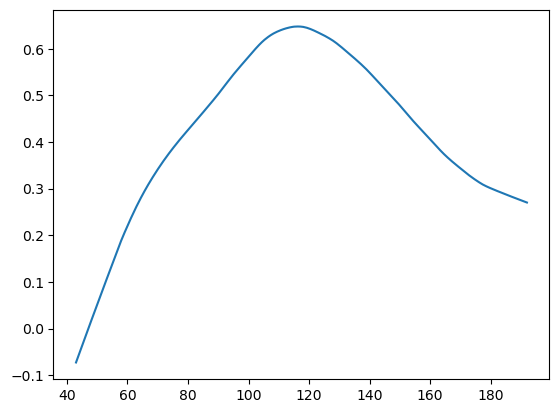

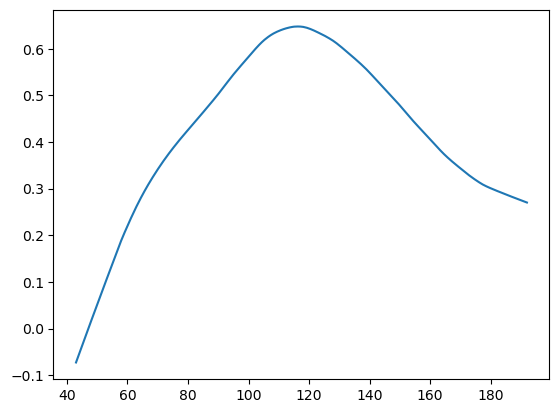

In [163]:
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
DATAX = np.asarray([NDVI[30].data_matrix.flatten(),NDVI[31].data_matrix.flatten(),NDVI[32].data_matrix.flatten(),NDVI[33].data_matrix.flatten(),NDVI[34].data_matrix.flatten(),NDVI[35].data_matrix.flatten(),NDVI[36].data_matrix.flatten(),NDVI[37].data_matrix.flatten(),NDVI[38].data_matrix.flatten(),NDVI[39].data_matrix.flatten()])

print(DATAX.shape)
NDVI[30].plot()

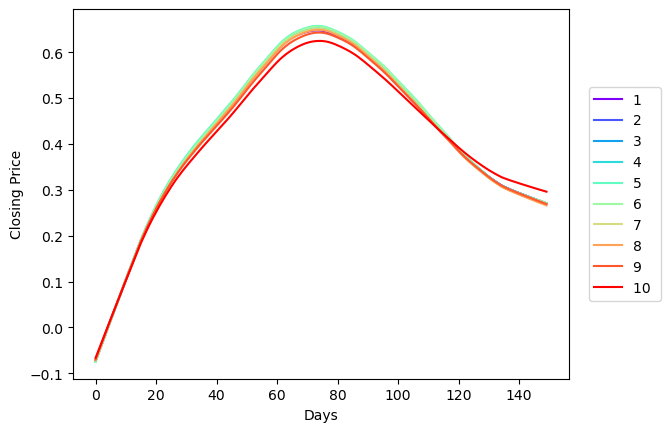

In [164]:
plot_series(DATAX)

[[-0.07256368  0.64758358]
 [-0.07397314  0.65213931]
 [-0.07326895  0.65290163]
 [-0.07459159  0.65525021]
 [-0.07538973  0.65741514]
 [-0.0743214   0.6557726 ]
 [-0.07175765  0.65119108]
 [-0.07119353  0.64872336]
 [-0.07014016  0.64292959]
 [-0.06658225  0.62473072]]


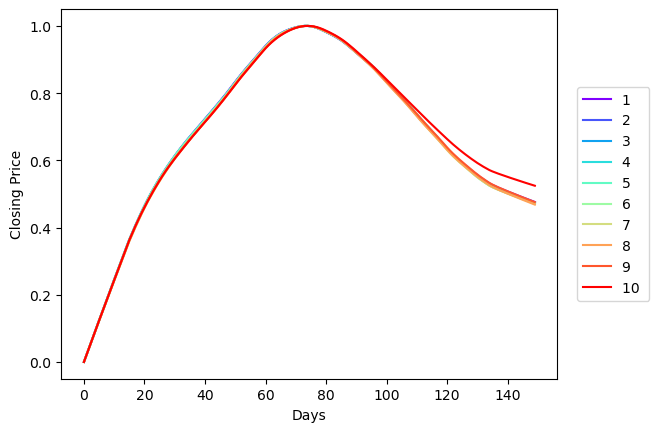

In [165]:
#Normalize data between 0 and 1
DATAX, mima = scaleit(DATAX)
print(mima)
plot_series(DATAX)

In [166]:
selected_series = 0 #Select one signal arbitrarily to train the dataset
scaled_data = DATAX[selected_series, :] 
scaled_data = np.reshape(scaled_data, (len(scaled_data),1)) 
scaled_data.shape

(150, 1)

In [167]:
#w < N < Q
window = 30 #Size of the window in days
test_samples = 50 #Number of test samples
N = len(scaled_data) - test_samples - window
print(N)

70


In [168]:
trainX, trainY, testX, testY, X = data_preparation(window, scaled_data, N,f)
#print(trainX)
#print(trainY.shape)
print(type(trainX))
print(trainY)

<class 'numpy.ndarray'>
[[[0.61358134]
  [0.62569854]
  [0.6374408 ]
  ...
  [0.79886322]
  [0.81040196]
  [0.82216871]]

 [[0.62569854]
  [0.6374408 ]
  [0.64886758]
  ...
  [0.81040196]
  [0.82216871]
  [0.83398809]]

 [[0.6374408 ]
  [0.64886758]
  [0.66002978]
  ...
  [0.82216871]
  [0.83398809]
  [0.84566802]]

 ...

 [[0.86275194]
  [0.85307854]
  [0.84321451]
  ...
  [0.69342116]
  [0.68388448]
  [0.6743418 ]]

 [[0.85307854]
  [0.84321451]
  [0.83335652]
  ...
  [0.68388448]
  [0.6743418 ]
  [0.66458659]]

 [[0.84321451]
  [0.83335652]
  [0.82365722]
  ...
  [0.6743418 ]
  [0.66458659]
  [0.65462734]]]


In [169]:
lstm_model = LSTM_Model(f)
gru_model = GRU_Model(f)
epochs = 100 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               66560     
                                                                 
 dense_12 (Dense)            (None, 20)                2580      
                                                                 
Total params: 69,140
Trainable params: 69,140
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 128)               50304     
                                                                 
 dense_13 (Dense)            (None, 20)                2580      
                                                                 
Total params: 52,884
Train

In [170]:
# Train LSTM model
#print(trainX)
#print(trainY)
lstm_trained = lstm_model.fit(trainX, trainY, shuffle=True, epochs=epochs)
# Train GRU model
gru_trained = gru_model.fit(trainX, trainY, shuffle=True, epochs=epochs)

Epoch 1/100
3/3 [==============================] - 2s 25ms/step - loss: 0.7624
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.5910
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.3652
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1250
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 0.1103
Epoch 6/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0231
Epoch 7/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0390
Epoch 8/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0248
Epoch 9/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0247
Epoch 10/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0188
Epoch 11/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0098
Epoch 12/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0095
Epoch 13/100
3/3 [==============================]

In [172]:
#Testing
s=(10,6) 
s=np.ones(s)  #for the results
print(testX)
for j in range(0,10):
  scaled_data = DATAX[j, :] #Changes the index of time_series
  scaled_data = np.reshape(scaled_data, (len(scaled_data),1)) 
  scaled_data.shape
  _ , _ , testX, testY, _ = data_preparation(window, scaled_data, N, f)
  y_pred_lstm = lstm_model.predict(testX)
  y_pred_gru = gru_model.predict(testX)
  y_baseline = baselinef(testX,f) 
  testY = np.reshape(testY, (testY.shape[0],testY.shape[1]))
  print(testY.shape)
  s[j,0] = np.sqrt(mean_squared_error(testY, y_pred_lstm))
  s[j,1] = np.sqrt(mean_squared_error(testY, y_pred_gru))
  s[j,2] = np.sqrt(mean_squared_error(testY, y_baseline))
  s[j,0+3] = mda(testY, y_pred_lstm)
  s[j,1+3] = mda(testY, y_pred_gru)
  s[j,2+3] = mda(testY, y_baseline)

[[[0.99592224]
  [0.99799909]
  [0.99942349]
  [1.        ]
  [0.99984079]
  [0.99890008]
  [0.99693706]
  [0.99405408]
  [0.99047769]
  [0.98640976]
  [0.98207663]
  [0.97766433]
  [0.97313243]
  [0.9682228 ]
  [0.96294012]
  [0.95720049]
  [0.95073535]
  [0.94366172]
  [0.93620293]
  [0.92852474]
  [0.92077857]
  [0.91306986]
  [0.9053546 ]
  [0.89743368]
  [0.88929311]
  [0.88089278]
  [0.87206005]
  [0.86275194]
  [0.85307854]
  [0.84321451]]

 [[0.99799909]
  [0.99942349]
  [1.        ]
  [0.99984079]
  [0.99890008]
  [0.99693706]
  [0.99405408]
  [0.99047769]
  [0.98640976]
  [0.98207663]
  [0.97766433]
  [0.97313243]
  [0.9682228 ]
  [0.96294012]
  [0.95720049]
  [0.95073535]
  [0.94366172]
  [0.93620293]
  [0.92852474]
  [0.92077857]
  [0.91306986]
  [0.9053546 ]
  [0.89743368]
  [0.88929311]
  [0.88089278]
  [0.87206005]
  [0.86275194]
  [0.85307854]
  [0.84321451]
  [0.83335652]]

 [[0.99942349]
  [1.        ]
  [0.99984079]
  [0.99890008]
  [0.99693706]
  [0.99405408]
  [0.9

In [173]:
print('Mean values')
np.mean(s, axis=0)

Mean values


array([0.29303755, 0.18352227, 0.10033622, 0.74833333, 1.        ,
       1.        ])

In [174]:
print('Standard Deviation')
np.std(s, axis=0)

Standard Deviation


array([0.00959752, 0.00682736, 0.00414677, 0.005     , 0.        ,
       0.        ])

In [175]:
#Statistical tests
statisticaltests(s)

LSTM and Baseline (RMSE)
U=100.0. p = 0.00018267179110955002
GRU and Baseline (RMSE)
U=100.0. p = 0.00018267179110955002
LSTM and GRU (RMSE)
U=100.0. p = 0.00018267179110955002
LSTM and Baseline (DA)
U=0.0. p = 2.428174732475476e-05
GRU and Baseline (DA)
U=50.0. p = 1.0
LSTM and GRU (DA)
U=0.0. p = 2.428174732475476e-05


In [176]:
#use this code to save the models
if experiment == 1:
  ex = 'B'
else:
  ex = 'A'
gru_model.save(thepath+'/GRU_'+str(ex)+str(f)) #Saves GRU
lstm_model.save(thepath+'/LSTM_'+str(ex)+str(f)) #Saves LSTM

INFO:tensorflow:Assets written to: sample_data/GRU_B20\assets


INFO:tensorflow:Assets written to: sample_data/GRU_B20\assets


INFO:tensorflow:Assets written to: sample_data/LSTM_B20\assets


INFO:tensorflow:Assets written to: sample_data/LSTM_B20\assets


In [177]:
#Rescale for visual inspection
testY = rescaleit(testY,mima,j)
y_pred_lstm = rescaleit(y_pred_lstm,mima,j)
y_pred_gru = rescaleit(y_pred_gru,mima,j)
y_baseline = rescaleit(y_baseline,mima,j)

In [178]:
if f == 1: 
  plt.plot(testY[0:100], label = 'Actual')
  plt.plot(y_baseline[0:100], label = 'Baseline prediction')
  plt.plot(y_pred_lstm[0:100], label = 'LSTM prediction')
  plt.plot(y_pred_gru[0:100], label = 'GRU prediction')
  
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=True, ncol=5)
  #plt.legend()
  plt.xlabel("Days")
  if experiment ==1:
    plt.ylabel("Closing Price")
  else:
    plt.ylabel("Value")

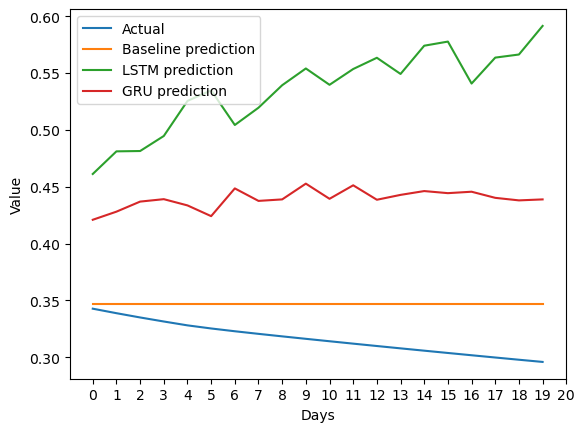

In [179]:
g = 30 #Chooses one of the tests samples
if f == 20:
  plt.plot(testY[g,:], label = 'Actual')
  plt.plot(y_baseline[g,:], label = 'Baseline prediction')
  plt.plot(y_pred_lstm[g,:], label = 'LSTM prediction')
  plt.plot(y_pred_gru[g,:], label = 'GRU prediction')
  plt.legend()
  plt.xlabel('Days')
  days = np.arange(testY.shape[1]+1)
  new_list = range(math.floor(min(days)), math.ceil(max(days))+1)
  plt.xticks(new_list)
  plt.ylabel('Value')

Text(0, 0.5, 'MSE Loss')

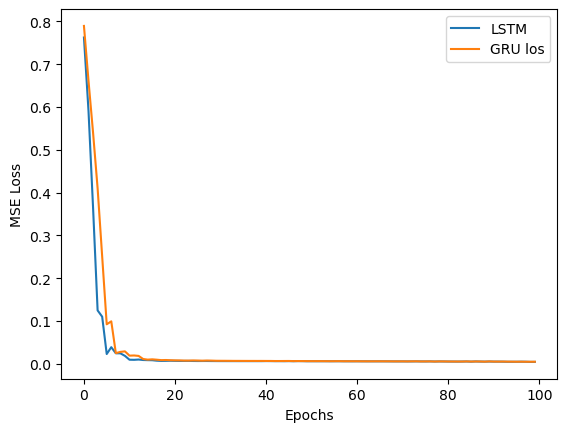

In [180]:
#"""Plot loss function and Predictions"""
plt.plot(lstm_trained.history['loss'], label = 'LSTM')
plt.plot(gru_trained.history['loss'], label = 'GRU los')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

In [181]:
print(y_pred_lstm.shape)
print(y_pred_gru) 

(31, 20)
[[0.5443335  0.54158574 0.53979105 0.5443219  0.54048866 0.533388
  0.5422389  0.53555655 0.5387347  0.5506546  0.5400148  0.539097
  0.52743757 0.53460765 0.53612477 0.5327342  0.52965117 0.5147729
  0.51284105 0.5220285 ]
 [0.5401455  0.53768396 0.53623104 0.5407195  0.5367502  0.5294338
  0.5390029  0.5320282  0.53519154 0.5473408  0.5364418  0.5359821
  0.52413195 0.5313618  0.5329636  0.5295827  0.52662283 0.51186925
  0.509939   0.5189922 ]
 [0.5359019  0.5337302  0.5326251  0.5370647  0.53297037 0.525452
  0.53572404 0.5284739  0.5316189  0.5439765  0.5328371  0.53283167
  0.52081835 0.52808154 0.52977437 0.52640045 0.52357227 0.5089655
  0.50703293 0.5159391 ]
 [0.5316273  0.529749   0.52899474 0.53337896 0.52917176 0.52147114
  0.5324218  0.52491826 0.5280397  0.5405791  0.52922314 0.52966887
  0.51751906 0.52479124 0.52657634 0.52320826 0.5205189  0.5060862
  0.5041491  0.5128906 ]
 [0.5273375  0.5257582  0.52535814 0.5296814  0.5253702  0.51750696
  0.52911323 0.521